# Implementation of the Pressure model

In [1]:
#Main Packages
import pandas as pd
import numpy as np
import json
import seaborn as sns
import itertools

#Plotting
import matplotlib.pyplot as plt
from xgboost import plot_importance

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Sklearn metrics
from sklearn.metrics import roc_curve, f1_score, roc_auc_score, precision_recall_curve, auc, accuracy_score,confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

#Imbalanced learning package for synthetic data
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids

#Model Packages
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#### Choose dataset to load

In [2]:
data = pd.read_csv("FixedRBF.csv")

In [3]:
data

,Frame,MinDistance,CentroidDistance1,CentroidDistance2,CentroidDistance3,ClusterSize1,ClusterSize2,ClusterSize3,Diameter1,Diameter2,Diameter3,FreePlayers,DistanceGoal,GoalAngle,MinProjectedVelocity,SuccessFlag
0,912,7.705806,10.444038,24.684791,27.159855,5,3,2,33.257856,26.075020,20.799708,8,48.811529,0.149684,2.376283,1
1,939,11.845662,15.332945,31.041474,33.079794,4,3,3,25.423354,22.133717,22.728152,8,62.193108,0.116665,4.266759,1
2,976,2.108485,6.968124,29.230925,44.272112,2,6,2,17.689055,25.308394,19.321853,5,71.102765,0.096506,4.039890,1
3,1034,2.386976,5.902807,16.034957,22.809425,4,3,3,23.744742,16.379330,15.477753,6,51.758143,0.138251,3.845597,1
4,1101,2.638369,9.377849,21.380085,34.311514,4,3,3,19.731816,16.453666,18.948508,3,62.311629,0.111638,2.475264,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,78572,1.776909,8.062058,20.796544,23.922344,4,3,3,16.451129,17.707978,23.599354,5,59.941455,0.116908,1.766963,0
3452,78601,1.924622,7.463557,17.777552,27.337346,4,3,3,19.473374,22.609151,26.253747,6,41.199346,0.168391,4.107820,1
3453,78669,3.890049,8.979155,21.020422,38.649378,5,2,3,27.452253,7.174080,21.133181,2,26.364390,0.190001,0.893161,0
3454,78724,2.655926,2.899647,14.797049,21.385538,5,3,2,13.686834,21.733689,16.277483,8,77.990737,0.093759,0.420312,1


#### Correlation matrix

In [4]:
data.corr()

,Frame,MinDistance,CentroidDistance1,CentroidDistance2,CentroidDistance3,ClusterSize1,ClusterSize2,ClusterSize3,Diameter1,Diameter2,Diameter3,FreePlayers,DistanceGoal,GoalAngle,MinProjectedVelocity,SuccessFlag
Frame,1.000000,0.116146,0.014941,-0.086047,-0.062408,-0.004829,0.032030,-0.028670,-0.066967,-0.049849,-0.058794,-0.035392,-0.040929,0.066420,0.057773,-0.009893
MinDistance,0.116146,1.000000,0.704112,0.361725,0.315537,-0.256961,0.122371,0.186871,0.046812,0.046432,0.051750,-0.223698,0.371359,-0.228967,0.032551,0.176924
CentroidDistance1,0.014941,0.704112,1.000000,0.475727,0.567879,-0.202374,0.062754,0.183568,0.216748,0.063833,0.079263,-0.396601,0.413445,-0.280029,0.064653,0.154086
CentroidDistance2,-0.086047,0.361725,0.475727,1.000000,0.688408,-0.095220,-0.026067,0.146549,0.168175,0.178379,0.153140,-0.504229,0.420312,-0.287550,0.096713,0.086474
CentroidDistance3,-0.062408,0.315537,0.567879,0.688408,1.000000,-0.109697,0.105773,0.021829,0.291931,0.262602,0.123460,-0.534837,0.339709,-0.221878,0.059580,0.030636
ClusterSize1,-0.004829,-0.256961,-0.202374,-0.095220,-0.109697,1.000000,-0.637858,-0.552271,0.395283,-0.311931,-0.318339,0.216768,-0.252422,0.189762,-0.066757,-0.102435
ClusterSize2,0.032030,0.122371,0.062754,-0.026067,0.105773,-0.637858,1.000000,-0.289780,-0.246209,0.484039,-0.152890,-0.081825,0.054737,-0.049792,0.002720,0.017442
ClusterSize3,-0.028670,0.186871,0.183568,0.146549,0.021829,-0.552271,-0.289780,1.000000,-0.224717,-0.136310,0.561107,-0.180811,0.254441,-0.181924,0.080017,0.108419
Diameter1,-0.066967,0.046812,0.216748,0.168175,0.291931,0.395283,-0.246209,-0.224717,1.000000,-0.060090,-0.116918,-0.055324,0.086068,-0.061311,0.014876,0.011873
Diameter2,-0.049849,0.046432,0.063833,0.178379,0.262602,-0.311931,0.484039,-0.136310,-0.060090,1.000000,-0.051462,-0.108379,0.132065,-0.105409,0.009724,-0.005235


In [5]:
data.describe()

,Frame,MinDistance,CentroidDistance1,CentroidDistance2,CentroidDistance3,ClusterSize1,ClusterSize2,ClusterSize3,Diameter1,Diameter2,Diameter3,FreePlayers,DistanceGoal,GoalAngle,MinProjectedVelocity,SuccessFlag
count,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000
mean,36673.080729,4.573778,8.397084,22.387371,31.369364,4.076100,3.216146,2.707755,17.534402,17.807202,16.381470,5.302951,59.657388,0.132532,0.927956,0.668403
std,22491.274316,3.498934,5.084568,7.866048,8.986792,1.120908,0.976354,0.901973,5.401531,6.743501,7.057648,1.961113,20.473613,0.073174,2.112911,0.470855
min,145.000000,0.036444,0.082678,5.515846,10.579105,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.495086,0.005073,-7.785605,0.000000
25%,18756.500000,2.099896,4.583275,16.518020,25.033585,3.000000,3.000000,2.000000,14.027637,13.581765,12.204736,4.000000,45.153337,0.093770,-0.458324,0.000000
50%,33920.500000,3.562475,7.414253,21.578168,30.612784,4.000000,3.000000,3.000000,17.264327,17.430440,16.572091,5.000000,60.351382,0.114416,0.906376,1.000000
75%,49284.000000,5.980790,11.154355,27.344782,37.075995,5.000000,4.000000,3.000000,20.627028,21.783278,20.899103,7.000000,75.150498,0.147162,2.359061,1.000000
max,86327.000000,28.399314,31.954777,54.892572,99.965950,7.000000,7.000000,6.000000,50.308019,54.812783,45.418867,10.000000,105.302867,1.349157,7.154978,1.000000


In [6]:
x = data.drop(['SuccessFlag','Frame'], axis=1)
y = data['SuccessFlag']

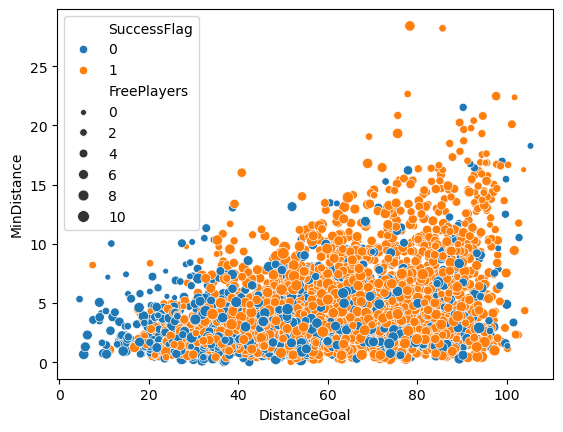

In [7]:
sns.scatterplot(x= 'DistanceGoal', 
           y= 'MinDistance', 
           data=data, 
           hue= 'SuccessFlag',
           size = 'FreePlayers'
)

plt.xlabel("DistanceGoal")
plt.ylabel("MinDistance")
 
plt.show()

##### Data Standardization

In [8]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

##### Train/test split

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split( 
    x, y, test_size=0.25, random_state=2023)

##### Implementation of oversampling and undersampling methods

In [10]:
oversample = SMOTE(random_state = 2023)
xtrain_smote, ytrain_smote = oversample.fit_resample(xtrain, ytrain)

In [11]:
oversample = ADASYN(random_state = 2023)
xtrain_ada, ytrain_ada = oversample.fit_resample(xtrain, ytrain)

In [12]:
cc = ClusterCentroids(random_state = 2023)
xtrain_res, ytrain_res = cc.fit_resample(xtrain, ytrain)

/home/macaco3001/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Perform a best subset search for logistic regression in terms of AUC score (Always outputs entire set)

In [13]:
def fit_logistic_regression(features, target):
    features = sm.add_constant(features)
    model = sm.Logit(target, features)
    result = model.fit(disp=0)
    return result

def get_best_model(features, target, candidate_predictors):
    best_model = None
    best_auc = 0.0

    for subset in itertools.combinations(candidate_predictors, len(candidate_predictors)):
        current_features = features[:, list(subset)]
        result = fit_logistic_regression(current_features, target)
        y_pred_prob = result.predict(sm.add_constant(current_features))
        current_auc = roc_auc_score(target, y_pred_prob)

        if current_auc > best_auc:
            best_auc = current_auc
            best_model = result
            best_subset = subset

    return best_model, best_subset

# Create a list of predictor indices
num_predictors = xtrain.shape[1]
predictor_indices = list(range(num_predictors))

# Get the best model and subset based on AUC
best_model, best_subset = get_best_model(xtrain, ytrain, predictor_indices)

# Print the best subset and model summary
print("Best Subset:", best_subset)
print(best_model.summary(xname = ['Intercept']+list(data.drop(['SuccessFlag','Frame'],axis = 1).columns))) #To have the variable names, we use the fact that all variables are used

# Make predictions on the test set using the best subset
xtest_subset = xtest[:, list(best_subset)]
ypred_prob = best_model.predict(sm.add_constant(xtest_subset))

# Evaluate the AUC of the model on the test set
test_auc = roc_auc_score(ytest, ypred_prob)
print("Test AUC:", test_auc)

Best Subset: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)
                           Logit Regression Results                           
Dep. Variable:            SuccessFlag   No. Observations:                 2592
Model:                          Logit   Df Residuals:                     2578
Method:                           MLE   Df Model:                           13
Date:                Fri, 10 May 2024   Pseudo R-squ.:                 0.06573
Time:                        15:19:16   Log-Likelihood:                -1541.4
converged:                       True   LL-Null:                       -1649.8
Covariance Type:            nonrobust   LLR p-value:                 4.604e-39
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.7562      0.045     16.927      0.000       0.669       0.844
MinDistance              0.2163      0.06

### Logistic regression fits

In [37]:
classifier = LogisticRegression(random_state = 2023) 
classifier.fit(xtrain, ytrain)
y_pred = classifier.predict(xtest)
y_score = classifier.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))
print('Coefficients:' ,classifier.coef_)
print('Intercept:' ,classifier.intercept_)

Accuracy :  0.7025462962962963
F1Score :  0.6620314380896392
AUC Score :  0.7003789817455095
PR-AUC Score: 0.8242972545200438
Best Threshold=0.695153
[[210  72]
 [258 324]]
Accuracy with custom threshold: 0.6180555555555556
F1Score with custom threshold: 0.6290967961826858
Coefficients: [[ 0.21616232  0.18684295  0.15701402 -0.14263747 -0.09778009  0.04132868
   0.07677737  0.01573522 -0.06021933 -0.01977347  0.33789683  0.23462585
  -0.10959814  0.00668366]]
Intercept: [0.75595337]


In [15]:
classifier = LogisticRegression(random_state = 2023) 
classifier.fit(xtrain_smote, ytrain_smote)
y_pred = classifier.predict(xtest)
y_score = classifier.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))
print('Coefficients:' ,classifier.coef_)
print('Intercept:' ,classifier.intercept_)

Accuracy :  0.6319444444444444
F1Score :  0.6429070094114343
AUC Score :  0.699653920206673
PR-AUC Score: 0.8246772387519814
Best Threshold=0.517718
[[198  84]
 [237 345]]
Accuracy with custom threshold: 0.6284722222222222
F1Score with custom threshold: 0.6399995792447649
Coefficients: [[ 0.26810493  0.19177887  0.17592602 -0.07436587 -0.13753048  0.05272877
   0.11383617  0.00862318 -0.07215895 -0.04327622  0.39461597  0.20351816
  -0.09942099  0.00617935]]
Intercept: [0.08133007]


In [16]:
classifier = LogisticRegression(random_state = 2023) 
classifier.fit(xtrain_ada, ytrain_ada)
y_pred = classifier.predict(xtest)
y_score = classifier.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))
print('Coefficients:' ,classifier.coef_)
print('Intercept:' ,classifier.intercept_)

Accuracy :  0.6284722222222222
F1Score :  0.6399821058778825
AUC Score :  0.6999402890497428
PR-AUC Score: 0.8263443312567753
Best Threshold=0.497288
[[198  84]
 [231 351]]
Accuracy with custom threshold: 0.6354166666666666
F1Score with custom threshold: 0.6467567180712694
Coefficients: [[ 0.21054914  0.20928954  0.1977944  -0.11331481 -0.10469591  0.05114484
   0.07474621  0.02392233 -0.06748397 -0.04116462  0.37467477  0.2025958
  -0.04193428 -0.00133051]]
Intercept: [0.01847472]


In [17]:
classifier = LogisticRegression(random_state = 2023) 
classifier.fit(xtrain_res, ytrain_res)
y_pred = classifier.predict(xtest)
y_score = classifier.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))
print('Coefficients:' ,classifier.coef_)
print('Intercept:' ,classifier.intercept_)

Accuracy :  0.6284722222222222
F1Score :  0.6400226729952997
AUC Score :  0.7021093807121443
PR-AUC Score: 0.8267695125571165
Best Threshold=0.464657
[[174 108]
 [179 403]]
Accuracy with custom threshold: 0.6678240740740741
F1Score with custom threshold: 0.6756056596539339
Coefficients: [[ 0.29449616  0.1018579   0.19529402  0.03562866 -0.14179642  0.06986659
   0.10058649  0.0580097  -0.08464757 -0.03604894  0.32084568  0.14934978
  -0.03765056 -0.01897224]]
Intercept: [0.05746336]


### Perform bayesian optimization over the xgboost hyperparameters with AUC as the scoring parameter

In [18]:
estimators = [
    ('clf', XGBClassifier(random_state=123, device = 'cuda',tree_method = 'hist')) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)

In [19]:
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0),
    'clf__n_estimators': Integer(100,1000),
    'clf__n_jobs': Integer(11.5,12.5), #Admiteddly lazy way to get 12 processors working, adjust if needed
}

opt = BayesSearchCV(pipe, search_space, cv=10, n_iter=100, scoring='roc_auc', random_state=123)

In [20]:
opt.fit(xtrain, ytrain)

/home/macaco3001/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [22:59:22] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device='cuda',
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       interaction_constrain...
                             'clf__n_estimators': Integer(low=100, high=1000, prior='uniform', transform='normalize'),
                             'clf__n_jobs': Integer(low=11.5, high=12.5, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [21]:
opt.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.5, colsample_bynode=1.0,
                               colsample_bytree=1.0, device='cuda',
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=3.9022057058351827,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.001, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=1000,
                               n_jobs=12, num_parallel_tree=None,
                               random_state=123, ...))])

In [22]:
opt.best_score_

0.6635583975722852

In [23]:
opt.score(xtest, ytest)

0.7166593551217373

In [24]:
opt.best_estimator_.steps

[('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.5, colsample_bynode=1.0, colsample_bytree=1.0,
                device='cuda', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=3.9022057058351827, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.001, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=8, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=1000, n_jobs=12,
                num_parallel_tree=None, random_state=123, ...))]

## Models obtained:

For RBF:

model = XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.5, colsample_bynode=1.0, colsample_bytree=0.5,
                device='cuda', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=0.3404126229044155, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.003911225659823791,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=8, max_leaves=None,
                min_child_weight=None, monotone_constraints=None,
                multi_strategy=None, n_estimators=1000, n_jobs=12,
                num_parallel_tree=None, random_state=123)

For KNN:

model = XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.8445304034569212, colsample_bynode=1.0,
                colsample_bytree=0.5, device='cuda', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=4.733212503552665, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.48945402372274754,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=2, max_leaves=None,
                min_child_weight=None, monotone_constraints=None,
                multi_strategy=None, n_estimators=1000, n_jobs=12,
                num_parallel_tree=None, random_state=123)

For hierarchical:

model = XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.5, colsample_bynode=1.0, colsample_bytree=1.0,
                device='cuda', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=3.9022057058351827, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.001, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=8, max_leaves=None,
                min_child_weight=None, monotone_constraints=None,
                multi_strategy=None, n_estimators=1000, n_jobs=12,
                num_parallel_tree=None, random_state=123)

### XGBOOST fit

In [18]:
model = XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=0.5, colsample_bynode=1.0, colsample_bytree=0.5, device='cuda', early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=0.3404126229044155, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.003911225659823791, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=8, max_leaves=None, min_child_weight=None, monotone_constraints=None, multi_strategy=None, n_estimators=1000, n_jobs=12, num_parallel_tree=None, random_state=123)
model.fit(xtrain, ytrain)
y_pred = model.predict(xtest)
y_score = model.predict_proba(xtest)[:, 1]
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print("F1Score : ",f1_score(ytest, y_pred, average="weighted"))
print("AUC Score : ", roc_auc_score(ytest, y_score))
precision, recall, _= precision_recall_curve(ytest, y_score) 
pr_auc = auc(recall, precision)
print("PR-AUC Score:", pr_auc)
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, y_score)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
threshold = best_thresh
y_pred = (y_score >= best_thresh).astype(int)
print(confusion_matrix(ytest, y_pred))
print('Accuracy with custom threshold:' , accuracy_score(ytest, y_pred))
print('F1Score with custom threshold:' , f1_score(ytest, y_pred, average="weighted"))

Accuracy :  0.6979166666666666
F1Score :  0.6468627155988237
AUC Score :  0.716293777875265
PR-AUC Score: 0.839580760876212
Best Threshold=0.714118
[[222  60]
 [268 314]]
Accuracy with custom threshold: 0.6203703703703703
F1Score with custom threshold: 0.6302135649643616


/home/macaco3001/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:19:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


## Analysis on feature influence

#### Feature importance (gini index)

Text(0.5, 1.0, 'Feature Importance')

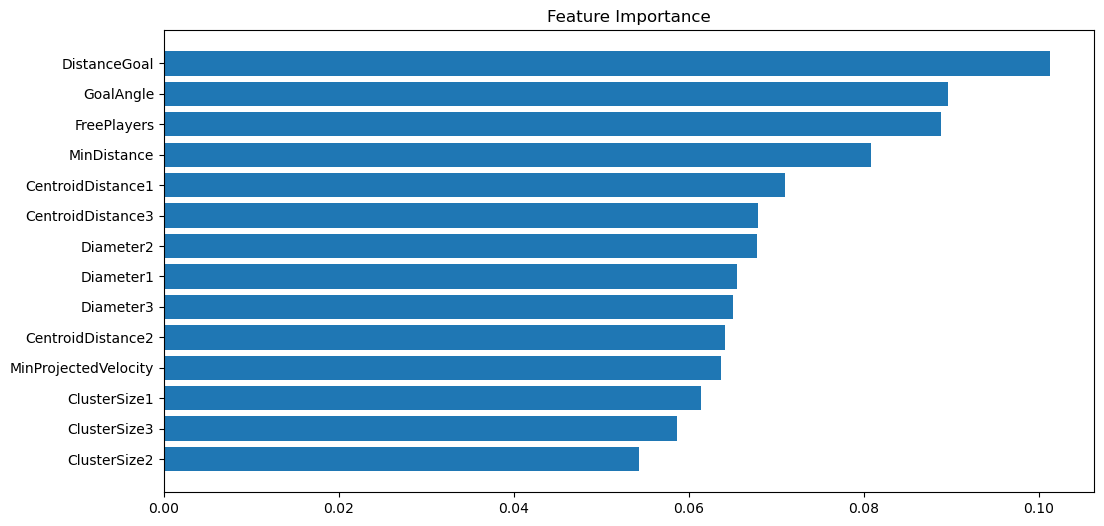

In [19]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(data.drop(['SuccessFlag','Frame'], axis=1).columns)[sorted_idx])
plt.title('Feature Importance')

#### SHAP values

In [20]:
import shap

# explain the model's predictions using SHAP
explainer = shap.Explainer(model,feature_names = list(data.drop(['SuccessFlag','Frame'], axis=1).columns))
shap_values = explainer(xtest)

/home/macaco3001/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


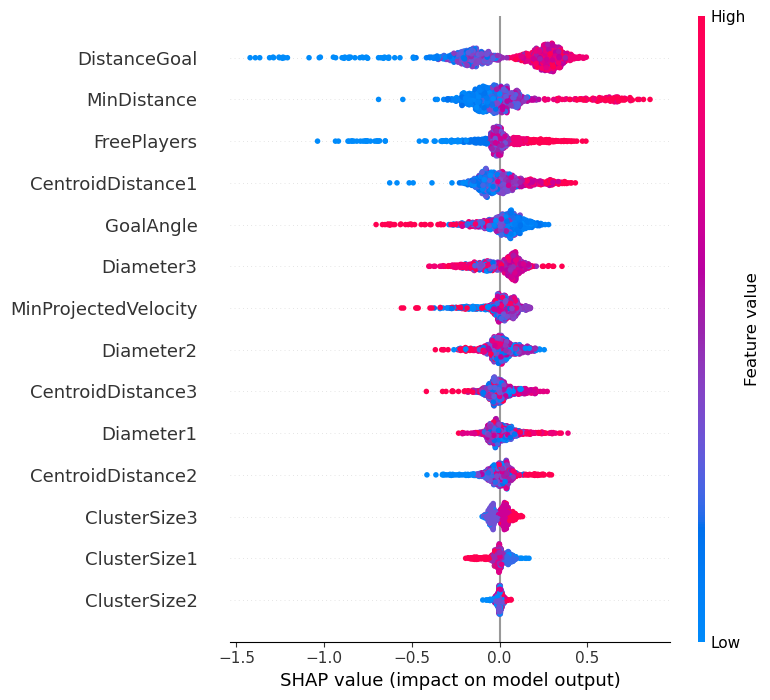

In [35]:
shap.summary_plot(shap_values, xtest)

#### PDP plots

/home/macaco3001/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:28:47] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


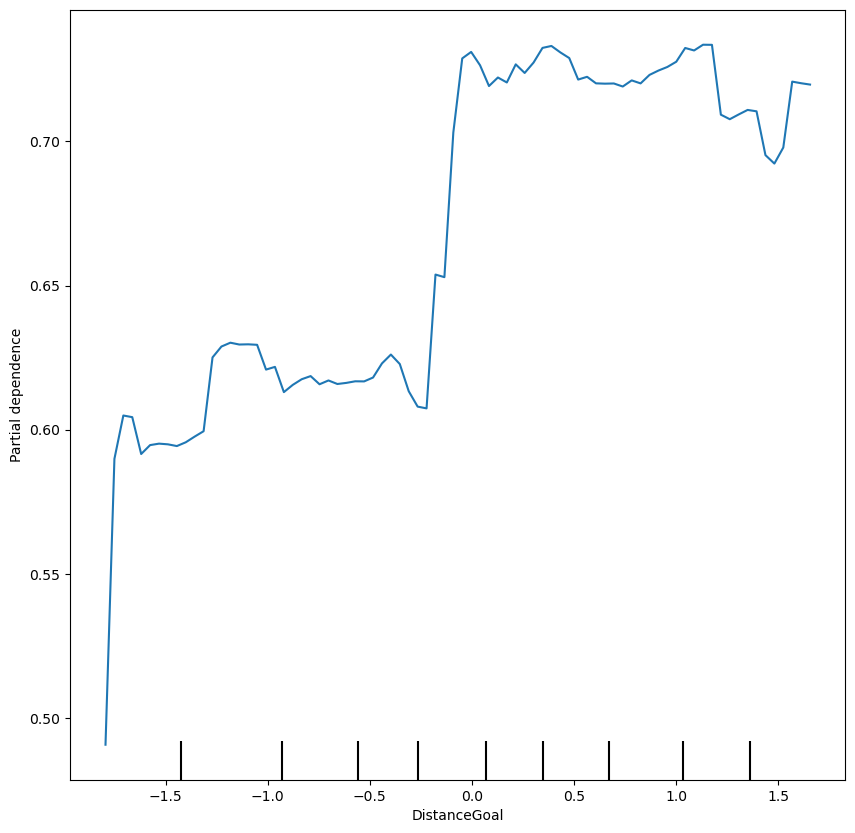

In [72]:
from sklearn.inspection import PartialDependenceDisplay

classifier = LogisticRegression(random_state = 2023) 
classifier.fit(xtrain, ytrain)
# Computing partial dependence plots
#features = list(range(14))
features = [11]
PartialDependenceDisplay.from_estimator(model, xtest, features, feature_names=list(data.drop(['SuccessFlag','Frame'], axis=1).columns),
                        n_jobs=3, grid_resolution=80)
#disp1 = PartialDependenceDisplay.from_estimator(model, xtest, features, feature_names=list(data.drop(['SuccessFlag','Frame'], axis=1).columns),
#                        n_jobs=3, grid_resolution=80, line_kw={"label": "XGBOOST"})
#disp2 = PartialDependenceDisplay.from_estimator(classifier, xtest, features, feature_names=list(data.drop(['SuccessFlag','Frame'], axis=1).columns),
#                        n_jobs=3, grid_resolution=80, ax = disp1.axes_, line_kw={"label": "Logistic Regression","color": "red"})
fig = plt.gcf()
fig.set_figwidth(10)
fig.set_figheight(10)
fig.subplots_adjust(wspace=1, hspace=0.5)